# Hyperparameter Tuning

* It’s easy to understand that many machine learning problems benefit from either precision or recall as their optimal performance metric but implementing the concept requires knowledge of a detailed process.

* Tuning a classifier for maximum sensitivity or specificity can be achieved in (at least) two main steps. 
    * The first is using GridSearchCV to fine tune your model and keep the classifier with the highest recall score. 
    * The second step is to adjust the decision threshold using the precision recall curve and the roc curve.

#### Start by loading the necessary libraries and the data

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

df = pd.read_csv('data.csv')

#### The class distribution can be found by counting the diagnosis column. B for benign and M for malignant.

In [4]:
# class distribution
# diagnosis: B = 0, M = 1
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

#### Convert the class labels and split the data into training and test sets. train_test_split with stratify=True results in consistent class distribution between training and test sets:

In [7]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
targets = df['diagnosis']

df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)


In [8]:
    X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

#### train_test_split with stratify=True results in consistent class distribution betwen training and test sets.

In [9]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.626761
1    0.373239
Name: diagnosis, dtype: float64
y_test class distribution
0    0.629371
1    0.370629
Name: diagnosis, dtype: float64


## Step 1: First strategy: Optimize for sensitivity using GridSearchCV and scoring.

#### First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for GridSearchCV.

In [12]:
clf = RandomForestClassifier(n_jobs=-1)# Decide the algorithm to be tuned

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.

In [11]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

The function below uses GridSearchCV to fit several classifiers according to the combinations of parameters in the param_grid. The scores from scorers are recorded and the best model (as scored by the refit argument) will be selected and "refit" to the full training data for downstream use. This also makes predictions on the held out X_test and prints the confusion matrix to show performance.

The point of the wrapper function is to quickly reuse the code to fit the best classifier according to the type of scoring metric chosen. First, try precision_score, which should limit the number of false positives. This isn't well-suited for the goal of maxium sensitivity, but allows us to quickly show the difference between a classifier optimized for precision_score and one optimized for recall_score.

In [13]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [14]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 5, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        89         1
pos         6        47


In [17]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
33,0.964439,0.930536,0.960094,5,5,5,300
56,0.964018,0.924227,0.957746,15,5,5,100
49,0.964018,0.917919,0.955399,15,3,3,300
26,0.964018,0.930536,0.960094,5,3,5,100
31,0.964018,0.930536,0.960094,5,5,3,300


 -------------------------------------------------------------------------------------------------------------------------------

The precision, recall, and accuracy scores for every combination of the parameters in param_grid are stored in cv_results_. Here, a pandas DataFrame helps visualize the scores and parameters for each classifier iteration. This is included to show that although accuracy may be relatively consistent across classifiers, it's obvious that precision and recall have a trade-off. Sorting by precision, the best scoring model should be the first record. This can be checked by looking at the parameters of the first record and comparing them to grid_search.best_params_ above.

--------------------------------------------------------------------------------------------------------------------------------

### Theroy 

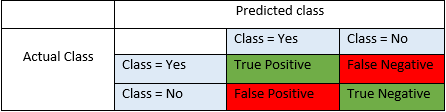

**Accuracy** : Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, **accuracy is a great** measure but only when you have symmetric datasets **where values of false positive and false negatives are almost same**. Therefore, you have to look at other parameters to evaluate the performance of your model. For our model, we have got 0.803 which means our model is approx. 80% accurate.

                                Accuracy = TP+TN/TP+FP+FN+TN

**Precision**  Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? **High precision relates to the low false positive rate**. We have got 0.788 precision which is pretty good.

                                Precision = TP/TP+FP
**Recall (Sensitivity)**  Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? **We have got recall of 0.631 which is good for this model as it’s above 0.5.** ||High the Recall better the model is||

                                Recall = TP/TP+FN  
**F1 score**  F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but **F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.**

                                F1 Score = 2*(Recall * Precision) / (Recall + Precision)
                                

# Step 2: First strategy: Optimize for sensitivity using GridSearchCV and scoring.

In [15]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 25, 'max_features': 20, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        89         1
pos         5        48


In [16]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
92,0.959161,0.949462,0.964789,25,20,5,100
88,0.953361,0.943153,0.960094,25,10,10,100
70,0.946632,0.943153,0.957746,15,20,10,100
94,0.952941,0.936952,0.957746,25,20,10,100
55,0.959161,0.936845,0.960094,15,5,3,300


**Comparing step1  and step2 table :**

The first strategy doesn't yield impressive results for recall_score(**step2**), it doesn't significantly reduce (if at all) the number of false negatives compared to the classifier optimized for precision_score(**step1**).(No significant improvement in the recall) Ideally, when designing a cancer diagnosis test, the classifier should strive for the fewest false negatives as possible.

**Now trying Strategy 2:Adjust the decision threshold -- Identify the operating point**

# Strategy 2:Adjust the decision threshold -- Identify the operating point

The precisoin_recall_curve and roc curve are useful tools to visualize the sensitivity-specificty tradeoff in the classifier. They can help inform a data scientist where to set the decision threshold of the model to maximize either sensitivity or specificity. This is called the "operating point" of the model.

**An important point to make this method generalizable to all classifiers in scikit-learn is to understand that some classifiers (like RandomForest) use .predict_proba() while others (like SVC) use .decision_function(). The idea is to get the "probability" that a sample is predicted to be in a class, not just the class returned from .predict(). The default threshold for RandomForestClassifier is 0.5**

## precision recall curve

### Method : 1

In [57]:
# this gives the probability [0,1] that each sample belongs to class 1
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  #predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[1.385e+01 1.518e+01 8.899e+01 5.874e+02 9.516e-02 7.688e-02 4.479e-02
 3.711e-02 2.110e-01 5.853e-02 2.479e-01 9.195e-01 1.830e+00 1.941e+01
 4.235e-03 1.541e-02 1.457e-02 1.043e-02 1.528e-02 1.593e-03 1.498e+01
 2.174e+01 9.837e+01 6.700e+02 1.185e-01 1.724e-01 1.456e-01 9.993e-02
 2.955e-01 6.912e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [22]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [23]:
def precision_recall_threshold(t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

**Re-execute this cell to tune the threshold until there are 0 False Negatives. On this particular run, I had to go all the way down to 0.0 before reducing the false negatives to 0. Unfortunately this means I predicted everything positive!**

     pred_neg  pred_pos
neg        89         1
pos         5        48


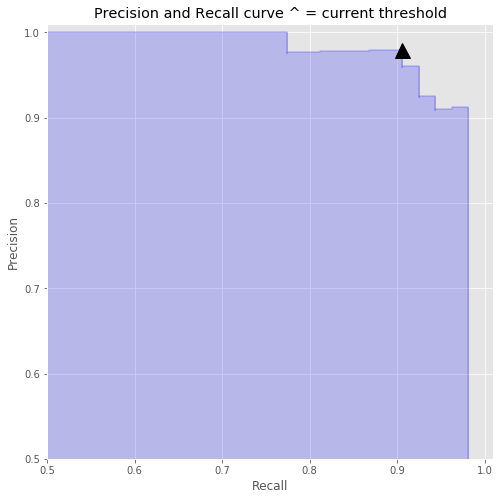

In [24]:
precision_recall_threshold()

### Method 2

Another way to view the tradeoff between precision and recall is to plot them together as a function of the decision threshold.

In [27]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision",)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

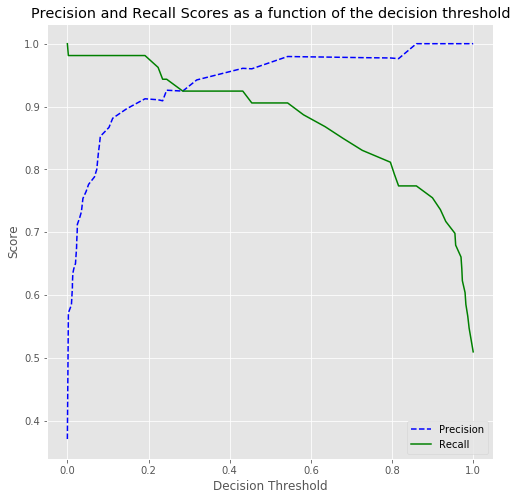

In [38]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

# ROC Curve

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.9816561844863732


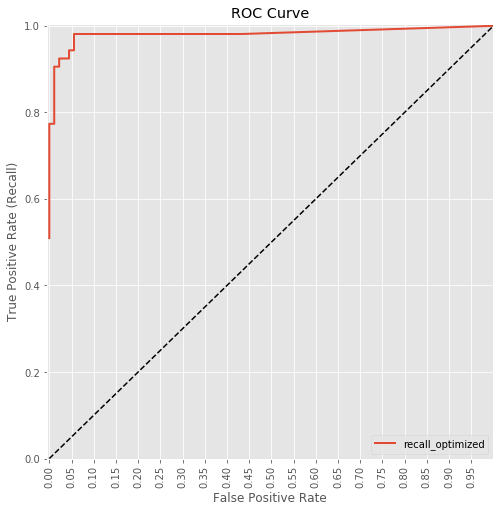

In [31]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [39]:
adjusted_classes(y_scores, 0.3)

[0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0]

In [41]:
a=accuracy_score(y_test,adjusted_classes(y_scores, 0.3))
r=recall_score(y_test,adjusted_classes(y_scores, 0.3))
p=precision_score(y_test,adjusted_classes(y_scores, 0.3))

In [43]:
F1_Score = 2*(r * p) / (r + p)

In [44]:
F1_Score

0.9333333333333333